## FORECASTING NATIONAL PARKS VISITS

The U.S. National Parks System includes 417 areas including national parks, monuments, battlefields, military parks, historical parks, historical sites, lakeshores, seashores, recreation areas, scenic rivers and trails, and the White House (see map in Figure 1). Every year, hundreds of millions of recreational visitors come to the parks. What do we know about the parks that can affect the visitor counts? Can we forecast the monthly visits to a given park accurately? To derive insights and answer these questions, we take a look at the historical visits data and the parks information released by the National Parks Service (NPS). 

For this problem, we obtained monthly visits data between 2010 and 2016 (source: https://irma.nps.gov/Stats/Reports/National). We also got park-specific data via the NPS API (https://www.nps.gov/subjects/developer/get-started.htm). The aggregated dataset park_visits.csv results in a total of 12 variables and 25587 observations. Each observation contains one record per park per month. Here's a detailed description of the variables:

- ParkName: The full name of the park.

- ParkType: The type of the park. For this study we restrict ourselves to the following more frequently visited types: National Battlefield, National Historic Site, National Historical Park, National Memorial, National Monument, National Park, National Recreation Area, and National Seashore.

- Region: The region of the park, including Alaska, Intermountain, Midwest, National Capital, Northeast, Pacific West, and Southeast.

- State: The abbreviation of the state where the park resides.

- Year, Month: the year and the month for the visits.

- lat, long: Latitude and longitude of the park.

- Cost: a simple extraction of the park's entrance fee. Some parks may have multiple levels of entrance fees (differ by transportation methods, age, military status, etc.); for this problem, we only extracted the first available cost information.

- logVisits: Natural logarithm of the recreational visits (with one added to the visits to avoid taking logs of zero) to the park in the given year and month.

- laglogVisits: the logVisits from last month.

- laglogVisitsYear: the logVisits from last year.

## Summary

### Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import datetime
import scipy.stats

%matplotlib inline
#sets the default autosave frequency in seconds
%autosave 60 
sns.set_style('dark')
sns.set(font_scale=1.2)

import warnings
warnings.filterwarnings('ignore')

from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

pd.set_option('display.max_columns',None)
#pd.set_option('display.max_rows',None)
pd.set_option('display.width', 1000)

np.random.seed(0)
np.set_printoptions(suppress=True)

Autosaving every 60 seconds


In [2]:
df = pd.read_csv("park_visits.csv")

In [3]:
df

,ParkName,ParkType,Region,State,Year,Month,lat,long,cost,logVisits,laglogVisits,laglogVisitsYear
0,Abraham Lincoln Birthplace NHP,National Historical Park,Southeast,KY,2010,1,37.585866,-85.673305,0.0,8.263333,NaN,NaN
1,Abraham Lincoln Birthplace NHP,National Historical Park,Southeast,KY,2010,2,37.585866,-85.673305,0.0,8.550241,8.263333,NaN
2,Abraham Lincoln Birthplace NHP,National Historical Park,Southeast,KY,2010,3,37.585866,-85.673305,0.0,8.994048,8.550241,NaN
3,Abraham Lincoln Birthplace NHP,National Historical Park,Southeast,KY,2010,4,37.585866,-85.673305,0.0,9.808022,8.994048,NaN
4,Abraham Lincoln Birthplace NHP,National Historical Park,Southeast,KY,2010,5,37.585866,-85.673305,0.0,9.867394,9.808022,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
25582,Zion NP,National Park,Intermountain,UT,2016,8,37.298393,-113.026514,30.0,13.076336,13.304622,13.029125
25583,Zion NP,National Park,Intermountain,UT,2016,9,37.298393,-113.026514,30.0,13.118006,13.076336,12.884619
25584,Zion NP,National Park,Intermountain,UT,2016,10,37.298393,-113.026514,30.0,12.931002,13.118006,12.660223
25585,Zion NP,National Park,Intermountain,UT,2016,11,37.298393,-113.026514,30.0,12.355664,12.931002,12.102882


## Exploratory Data Analysis

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25587 entries, 0 to 25586
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   ParkName          25587 non-null  object 
 1   ParkType          25587 non-null  object 
 2   Region            25587 non-null  object 
 3   State             25587 non-null  object 
 4   Year              25587 non-null  int64  
 5   Month             25587 non-null  int64  
 6   lat               25503 non-null  float64
 7   long              25503 non-null  float64
 8   cost              25587 non-null  float64
 9   logVisits         25587 non-null  float64
 10  laglogVisits      25282 non-null  float64
 11  laglogVisitsYear  21927 non-null  float64
dtypes: float64(6), int64(2), object(4)
memory usage: 2.3+ MB


In [5]:
df.describe()

,Year,Month,lat,long,cost,logVisits,laglogVisits,laglogVisitsYear
count,25587.000000,25587.000000,25503.000000,25503.000000,25587.000000,25587.000000,25282.000000,21927.000000
mean,2013.003517,6.500410,38.264148,-96.553684,4.997968,9.148891,9.156110,9.123890
std,1.998863,3.452137,8.170363,26.080984,7.839068,2.389602,2.387873,2.393828
min,2010.000000,1.000000,-14.228659,-169.850378,0.000000,0.000000,0.000000,0.000000
25%,2011.000000,4.000000,34.983877,-111.113563,0.000000,7.863651,7.872169,7.840116
50%,2013.000000,7.000000,38.564142,-94.355227,0.000000,9.243775,9.248503,9.219796
75%,2015.000000,10.000000,41.762085,-77.396377,7.000000,10.769821,10.775063,10.757743
max,2016.000000,12.000000,67.759616,144.692246,30.000000,14.198447,14.198447,14.187879


In [6]:
df.columns

Index(['ParkName', 'ParkType', 'Region', 'State', 'Year', 'Month', 'lat', 'long', 'cost', 'logVisits', 'laglogVisits', 'laglogVisitsYear'], dtype='object')

## Data Visualization

### Univariate Data Exploration

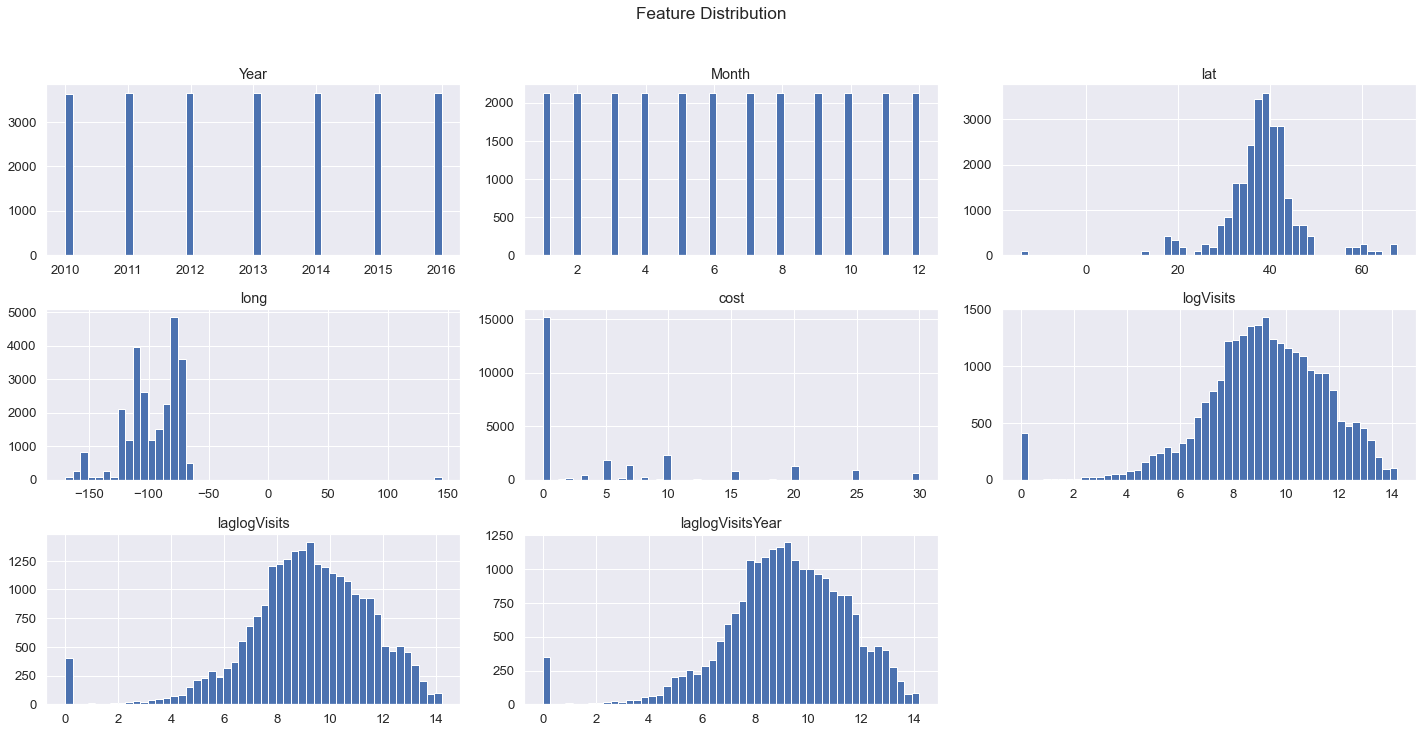

In [7]:
df.hist(bins=50, figsize=(20,10))
plt.suptitle('Feature Distribution', x=0.5, y=1.02, ha='center', fontsize='large')
plt.tight_layout()
plt.show()

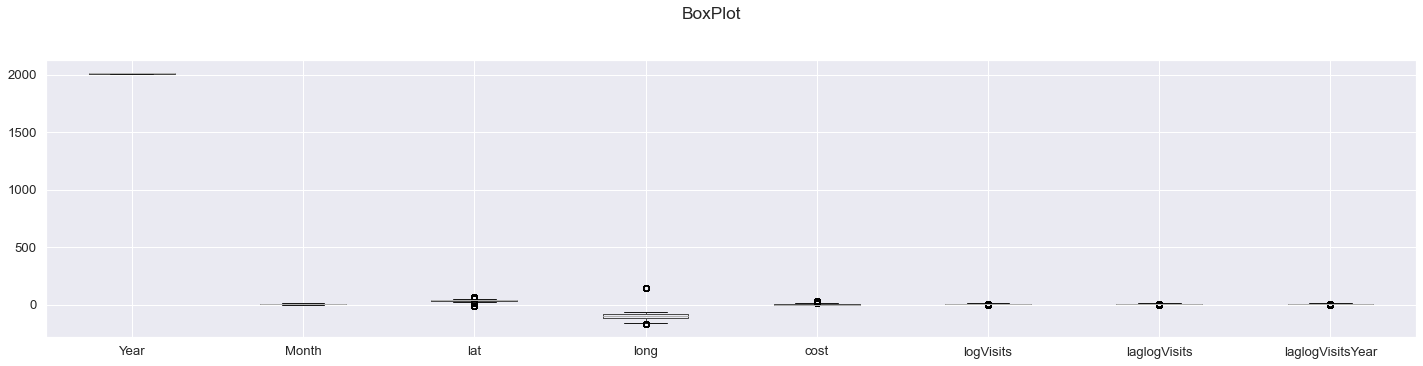

In [8]:
df.boxplot(figsize=(20,5))
plt.suptitle('BoxPlot', x=0.5, y=1.02, ha='center', fontsize='large')
plt.tight_layout()
plt.show()

### Problem 1 - Number of National Parks in Jan 2016 

In [9]:
df.head()

,ParkName,ParkType,Region,State,Year,Month,lat,long,cost,logVisits,laglogVisits,laglogVisitsYear
0,Abraham Lincoln Birthplace NHP,National Historical Park,Southeast,KY,2010,1,37.585866,-85.673305,0.0,8.263333,NaN,NaN
1,Abraham Lincoln Birthplace NHP,National Historical Park,Southeast,KY,2010,2,37.585866,-85.673305,0.0,8.550241,8.263333,NaN
2,Abraham Lincoln Birthplace NHP,National Historical Park,Southeast,KY,2010,3,37.585866,-85.673305,0.0,8.994048,8.550241,NaN
3,Abraham Lincoln Birthplace NHP,National Historical Park,Southeast,KY,2010,4,37.585866,-85.673305,0.0,9.808022,8.994048,NaN
4,Abraham Lincoln Birthplace NHP,National Historical Park,Southeast,KY,2010,5,37.585866,-85.673305,0.0,9.867394,9.808022,NaN


In [10]:
visits2016jul = df[(df["Month"] == 7) & (df["Year"] == 2016)]

In [11]:
visits2016jul

,ParkName,ParkType,Region,State,Year,Month,lat,long,cost,logVisits,laglogVisits,laglogVisitsYear
78,Abraham Lincoln Birthplace NHP,National Historical Park,Southeast,KY,2016,7,37.585866,-85.673305,0.0,10.873736,10.283088,10.052554
162,Acadia NP,National Park,Northeast,ME,2016,7,44.307775,-68.300633,25.0,13.454333,13.006753,13.315622
246,Adams NHP,National Historical Park,Northeast,MA,2016,7,42.255396,-71.011604,10.0,10.288103,10.182520,10.576942
330,African Burial Ground NM,National Monument,Northeast,NY,2016,7,40.714527,-74.004474,0.0,8.782169,8.584104,9.113829
414,Agate Fossil Beds NM,National Monument,Midwest,NE,2016,7,42.421704,-103.753886,0.0,8.183677,7.996317,7.977625
...,...,...,...,...,...,...,...,...,...,...,...,...
25245,Wright Brothers NMEM,National Memorial,Southeast,NC,2016,7,36.016377,-75.669972,7.0,11.253170,11.057014,11.315328
25329,Wupatki NM,National Monument,Intermountain,AZ,2016,7,35.557411,-111.395722,20.0,10.216655,10.225317,10.275637
25413,Yellowstone NP,National Park,Intermountain,WY,2016,7,44.598244,-110.547170,30.0,13.811420,13.639152,13.796025
25497,Yosemite NP,National Park,Pacific West,CA,2016,7,37.848833,-119.557187,30.0,13.567983,13.463987,13.347122


In [12]:
visits2016jul["ParkType"].value_counts(ascending=False)

National Historic Site      75
National Monument           68
National Park               57
National Historical Park    42
National Memorial           28
National Recreation Area    15
National Battlefield        10
National Seashore           10
Name: ParkType, dtype: int64

In [13]:
visits2016jul["logVisits"].max()

14.196995083262

In [14]:
visits2016jul[visits2016jul["logVisits"] == 14.196995083262]

,ParkName,ParkType,Region,State,Year,Month,lat,long,cost,logVisits,laglogVisits,laglogVisitsYear
11586,Great Smoky Mountains NP,National Park,Southeast,TN,2016,7,35.601164,-83.508183,0.0,14.196995,14.126034,14.181267


### Problem 2 - Relationship Between Region and Visits 

In [15]:
visits2016jul["Region"].value_counts()

Intermountain        75
Northeast            65
Southeast            48
Pacific West         47
Midwest              40
National Capital     18
Alaska               12
Name: Region, dtype: int64

In [16]:
visits2016jul.groupby(["Region"]).mean()

,Year,Month,lat,long,cost,logVisits,laglogVisits,laglogVisitsYear
Region,,,,,,,,
Alaska,2016,7,61.547752,-149.441544,0.833333,9.374157,9.015003,8.207701
Intermountain,2016,7,36.343675,-107.749860,9.160000,10.129625,10.010088,10.085582
Midwest,2016,7,41.064837,-93.619685,2.800000,9.747281,9.497106,9.640761
National Capital,2016,7,39.008807,-77.198343,1.472222,10.293175,10.282140,10.587112
Northeast,2016,7,40.831398,-74.617232,3.876923,9.914755,9.708259,9.836493
Pacific West,2016,7,36.465520,-120.356059,6.872340,10.767849,10.436952,10.612747
Southeast,2016,7,31.121042,-81.425799,2.333333,10.027672,9.910125,10.008342


### Problem 3 - Relationship Between Cost and Visits

In [17]:
visits2016jul.corr()

,Year,Month,lat,long,cost,logVisits,laglogVisits,laglogVisitsYear
Year,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Month,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
lat,NaN,NaN,1.000000,-0.221511,-0.014517,0.033507,0.008199,-0.047294
long,NaN,NaN,-0.221511,1.000000,-0.170515,-0.012419,0.005281,0.040525
cost,NaN,NaN,-0.014517,-0.170515,1.000000,0.401061,0.398253,0.399685
logVisits,NaN,NaN,0.033507,-0.012419,0.401061,1.000000,0.973283,0.944541
laglogVisits,NaN,NaN,0.008199,0.005281,0.398253,0.973283,1.000000,0.930446
laglogVisitsYear,NaN,NaN,-0.047294,0.040525,0.399685,0.944541,0.930446,1.000000


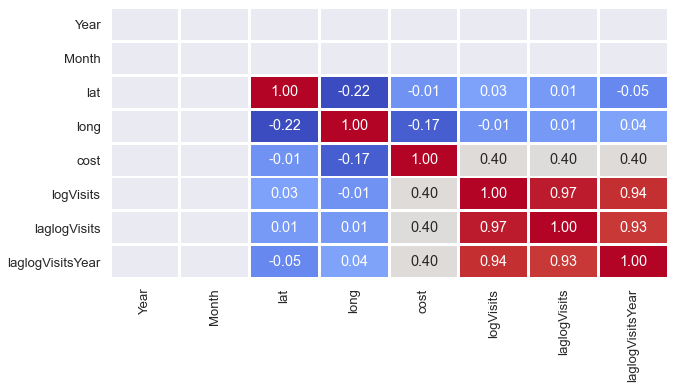

In [18]:
plt.figure(figsize=(10,5))
sns.heatmap(visits2016jul.corr(),cmap="coolwarm",annot=True,fmt='.2f',linewidths=2, cbar=False)
plt.show()

### Problem 4 - Time Series Plot of Visits 

In [19]:
ys = df[df["ParkName"] == "Yellowstone NP"]

In [20]:
ys

,ParkName,ParkType,Region,State,Year,Month,lat,long,cost,logVisits,laglogVisits,laglogVisitsYear
25335,Yellowstone NP,National Park,Intermountain,WY,2010,1,44.598244,-110.54717,30.0,10.150191,NaN,NaN
25336,Yellowstone NP,National Park,Intermountain,WY,2010,2,44.598244,-110.54717,30.0,10.278803,10.150191,NaN
25337,Yellowstone NP,National Park,Intermountain,WY,2010,3,44.598244,-110.54717,30.0,9.953658,10.278803,NaN
25338,Yellowstone NP,National Park,Intermountain,WY,2010,4,44.598244,-110.54717,30.0,10.397086,9.953658,NaN
25339,Yellowstone NP,National Park,Intermountain,WY,2010,5,44.598244,-110.54717,30.0,12.430999,10.397086,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
25414,Yellowstone NP,National Park,Intermountain,WY,2016,8,44.598244,-110.54717,30.0,13.642391,13.811420,13.658165
25415,Yellowstone NP,National Park,Intermountain,WY,2016,9,44.598244,-110.54717,30.0,13.461340,13.642391,13.430163
25416,Yellowstone NP,National Park,Intermountain,WY,2016,10,44.598244,-110.54717,30.0,12.396714,13.461340,12.437240
25417,Yellowstone NP,National Park,Intermountain,WY,2016,11,44.598244,-110.54717,30.0,10.115004,12.396714,9.310186


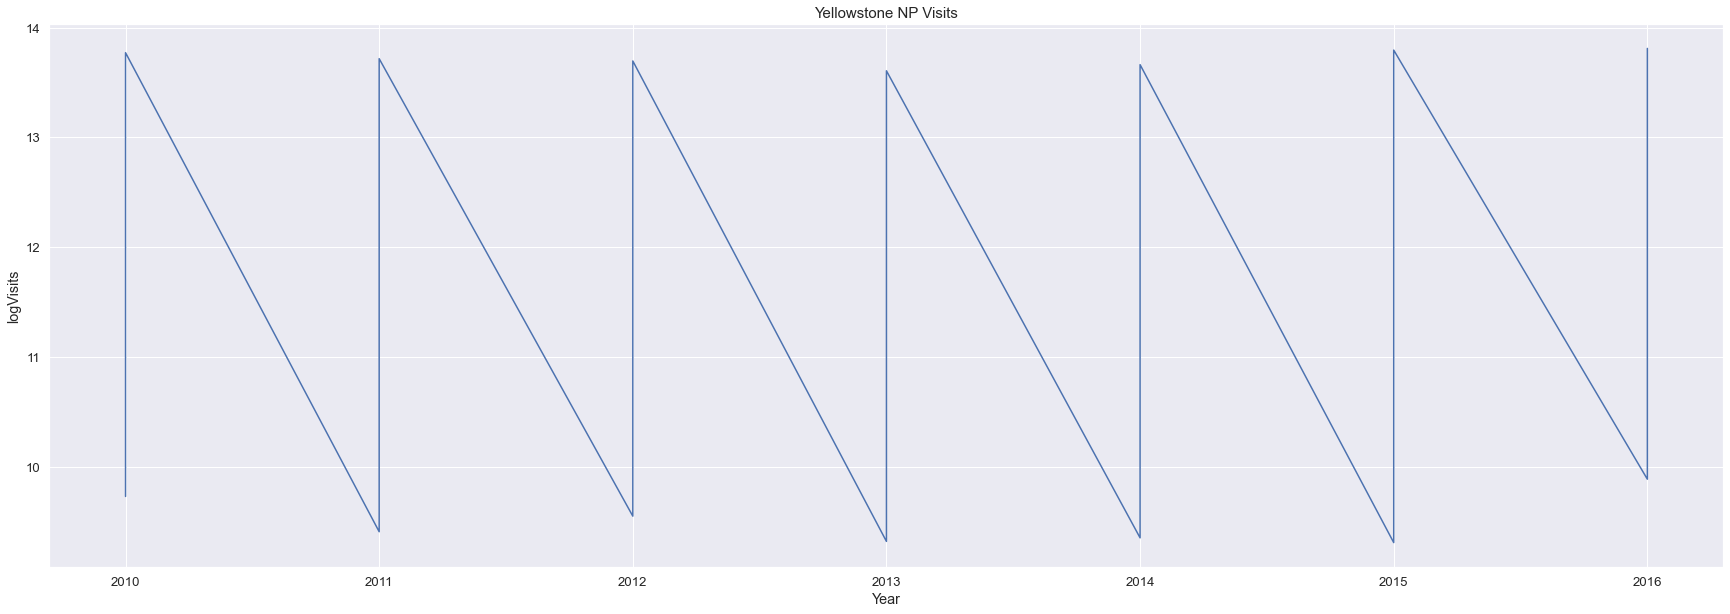

In [21]:
fig = plt.figure(figsize=(30,10))
sns.lineplot(x=ys.Year,y=ys.logVisits,data=ys, estimator=None)
plt.title("Yellowstone NP Visits", fontsize=15)
plt.show()

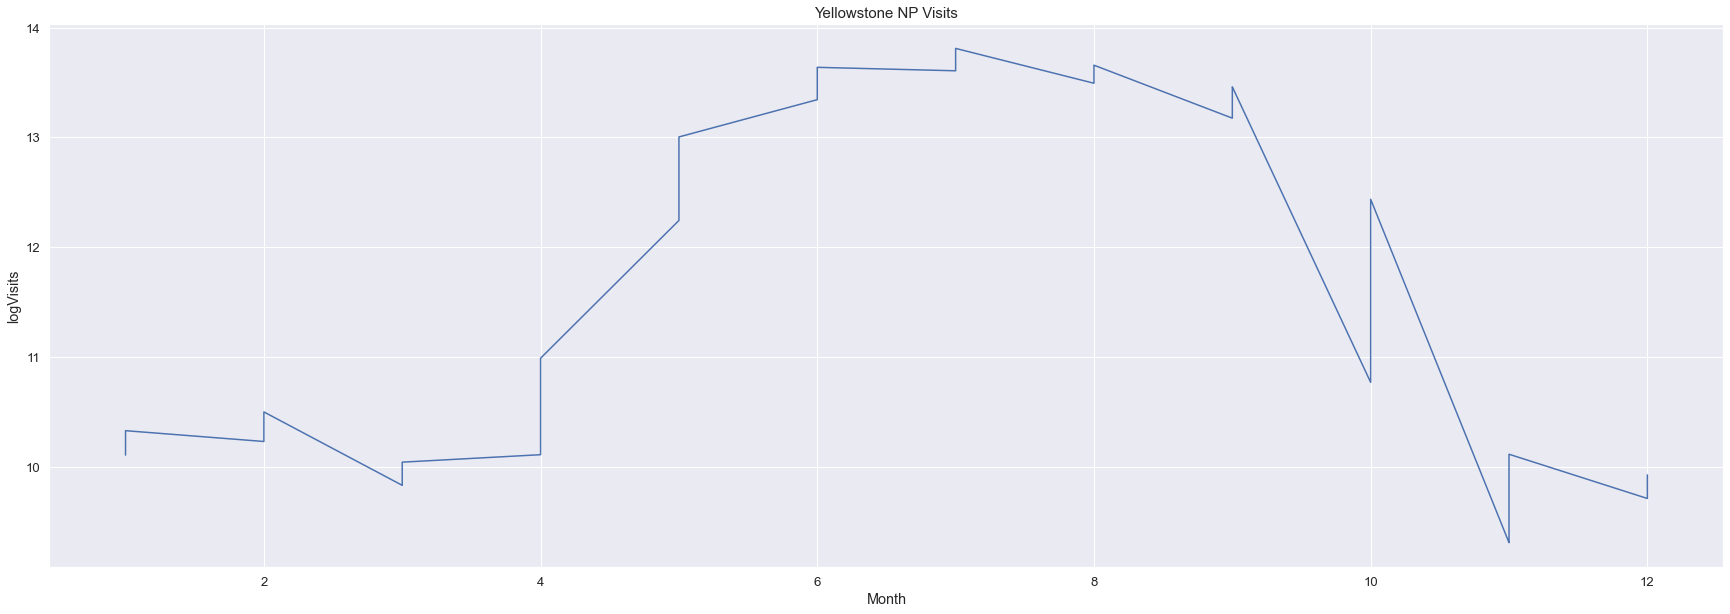

In [22]:
fig = plt.figure(figsize=(30,10))
sns.lineplot(x=ys.Month,y=ys.logVisits,data=ys, estimator=None)
plt.title("Yellowstone NP Visits", fontsize=15)
plt.show()

### Problem 5 - Missing Values

In [23]:
df.isnull().sum()

ParkName               0
ParkType               0
Region                 0
State                  0
Year                   0
Month                  0
lat                   84
long                  84
cost                   0
logVisits              0
laglogVisits         305
laglogVisitsYear    3660
dtype: int64

In [24]:
df.dropna(inplace=True)

In [25]:
df.isnull().sum()

ParkName            0
ParkType            0
Region              0
State               0
Year                0
Month               0
lat                 0
long                0
cost                0
logVisits           0
laglogVisits        0
laglogVisitsYear    0
dtype: int64

In [26]:
df.shape

(21855, 12)

## Data Preprocessing

In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21855 entries, 12 to 25586
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   ParkName          21855 non-null  object 
 1   ParkType          21855 non-null  object 
 2   Region            21855 non-null  object 
 3   State             21855 non-null  object 
 4   Year              21855 non-null  int64  
 5   Month             21855 non-null  int64  
 6   lat               21855 non-null  float64
 7   long              21855 non-null  float64
 8   cost              21855 non-null  float64
 9   logVisits         21855 non-null  float64
 10  laglogVisits      21855 non-null  float64
 11  laglogVisitsYear  21855 non-null  float64
dtypes: float64(6), int64(2), object(4)
memory usage: 2.2+ MB


In [28]:
df["Month"] = df["Month"].astype("category")

In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21855 entries, 12 to 25586
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   ParkName          21855 non-null  object  
 1   ParkType          21855 non-null  object  
 2   Region            21855 non-null  object  
 3   State             21855 non-null  object  
 4   Year              21855 non-null  int64   
 5   Month             21855 non-null  category
 6   lat               21855 non-null  float64 
 7   long              21855 non-null  float64 
 8   cost              21855 non-null  float64 
 9   logVisits         21855 non-null  float64 
 10  laglogVisits      21855 non-null  float64 
 11  laglogVisitsYear  21855 non-null  float64 
dtypes: category(1), float64(6), int64(1), object(4)
memory usage: 2.0+ MB


## Regression Analysis

In [30]:
df.columns

Index(['ParkName', 'ParkType', 'Region', 'State', 'Year', 'Month', 'lat', 'long', 'cost', 'logVisits', 'laglogVisits', 'laglogVisitsYear'], dtype='object')

In [31]:
df.reset_index(drop=True,inplace=True)

In [32]:
df1 = df.sort_values("Year")

In [33]:
df1

,ParkName,ParkType,Region,State,Year,Month,lat,long,cost,logVisits,laglogVisits,laglogVisitsYear
0,Abraham Lincoln Birthplace NHP,National Historical Park,Southeast,KY,2011,1,37.585866,-85.673305,0.0,7.880048,8.315077,8.263333
18986,Sunset Crater Volcano NM,National Monument,Intermountain,AZ,2011,12,35.371143,-111.510376,20.0,8.461258,9.179262,8.489616
7139,Fort McHenry NM & HS,National Monument,Northeast,MD,2011,12,39.263953,-76.580442,10.0,9.938469,10.499490,10.040725
7138,Fort McHenry NM & HS,National Monument,Northeast,MD,2011,11,39.263953,-76.580442,10.0,10.499490,10.954956,10.484669
7137,Fort McHenry NM & HS,National Monument,Northeast,MD,2011,10,39.263953,-76.580442,10.0,10.954956,11.248257,10.905479
...,...,...,...,...,...,...,...,...,...,...,...,...
9062,Glacier NP,National Park,Intermountain,MT,2016,3,48.684147,-113.800931,30.0,9.964489,9.714081,9.805875
9063,Glacier NP,National Park,Intermountain,MT,2016,4,48.684147,-113.800931,30.0,10.917377,9.964489,10.784586
9064,Glacier NP,National Park,Intermountain,MT,2016,5,48.684147,-113.800931,30.0,12.122289,10.917377,11.811117
19549,Thomas Stone NHS,National Historic Site,Northeast,MD,2016,11,38.529344,-77.037813,0.0,6.617403,7.011214,6.089045


In [34]:
train = df1[(df1["Year"]>=2011) & (df1["Year"]<=2014)]

In [35]:
train

,ParkName,ParkType,Region,State,Year,Month,lat,long,cost,logVisits,laglogVisits,laglogVisitsYear
0,Abraham Lincoln Birthplace NHP,National Historical Park,Southeast,KY,2011,1,37.585866,-85.673305,0.0,7.880048,8.315077,8.263333
18986,Sunset Crater Volcano NM,National Monument,Intermountain,AZ,2011,12,35.371143,-111.510376,20.0,8.461258,9.179262,8.489616
7139,Fort McHenry NM & HS,National Monument,Northeast,MD,2011,12,39.263953,-76.580442,10.0,9.938469,10.499490,10.040725
7138,Fort McHenry NM & HS,National Monument,Northeast,MD,2011,11,39.263953,-76.580442,10.0,10.499490,10.954956,10.484669
7137,Fort McHenry NM & HS,National Monument,Northeast,MD,2011,10,39.263953,-76.580442,10.0,10.954956,11.248257,10.905479
...,...,...,...,...,...,...,...,...,...,...,...,...
1485,Big Bend NP,National Park,Intermountain,TX,2014,10,29.298178,-103.229790,25.0,10.305045,10.020203,10.336438
18151,San Juan NHS,National Historic Site,Southeast,PR,2014,5,18.468739,-66.118486,5.0,11.503461,11.732743,11.486017
9189,Golden Gate NRA,National Recreation Area,Pacific West,CA,2014,10,37.859825,-122.600739,0.0,14.104430,14.164338,13.782078
9191,Golden Gate NRA,National Recreation Area,Pacific West,CA,2014,12,37.859825,-122.600739,0.0,13.912908,13.863764,13.965196


In [36]:
test = df1[(df1["Year"]>=2015) & (df1["Year"]<=2016)]

In [37]:
test

,ParkName,ParkType,Region,State,Year,Month,lat,long,cost,logVisits,laglogVisits,laglogVisitsYear
17805,Salinas Pueblo Missions NM,National Monument,Intermountain,NM,2015,7,34.354232,-106.205031,0.0,8.176673,7.852439,8.143517
20322,Virgin Islands NP,National Park,Southeast,VI,2015,4,18.342797,-64.741945,0.0,10.769179,10.927502,10.942633
20323,Virgin Islands NP,National Park,Southeast,VI,2015,5,18.342797,-64.741945,0.0,10.346987,10.769179,10.539059
20324,Virgin Islands NP,National Park,Southeast,VI,2015,6,18.342797,-64.741945,0.0,10.634388,10.346987,10.567541
20325,Virgin Islands NP,National Park,Southeast,VI,2015,7,18.342797,-64.741945,0.0,10.472573,10.634388,10.581546
...,...,...,...,...,...,...,...,...,...,...,...,...
9062,Glacier NP,National Park,Intermountain,MT,2016,3,48.684147,-113.800931,30.0,9.964489,9.714081,9.805875
9063,Glacier NP,National Park,Intermountain,MT,2016,4,48.684147,-113.800931,30.0,10.917377,9.964489,10.784586
9064,Glacier NP,National Park,Intermountain,MT,2016,5,48.684147,-113.800931,30.0,12.122289,10.917377,11.811117
19549,Thomas Stone NHS,National Historic Site,Northeast,MD,2016,11,38.529344,-77.037813,0.0,6.617403,7.011214,6.089045


In [38]:
y = train['logVisits']
X = train['laglogVisits']

In [39]:
X.shape, y.shape

((14559,), (14559,))

In [40]:
X = sm.add_constant(X)

In [41]:
model = sm.OLS(y,X).fit()

In [42]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              logVisits   R-squared:                       0.862
Model:                            OLS   Adj. R-squared:                  0.862
Method:                 Least Squares   F-statistic:                 9.117e+04
Date:                Mon, 16 Nov 2020   Prob (F-statistic):               0.00
Time:                        09:41:10   Log-Likelihood:                -18825.
No. Observations:               14559   AIC:                         3.765e+04
Df Residuals:                   14557   BIC:                         3.767e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.6595      0.029     22.801      0.000       0.603       0.716
laglogVisits     0.9279      0.003    301.949      0.000       0.922       0.934
==============================================================================
Omnibus:                     6626.778   Durbin-Watson:                   1.877
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1062418.767
Skew:                          -1.118   Prob(JB):                         0.00
Kurtosis:                      44.789   Cond. No.                         37.6
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [43]:
X.drop("const",axis=1,inplace=True)

In [44]:
X

,laglogVisits
0,8.315077
18986,9.179262
7139,10.499490
7138,10.954956
7137,11.248257
...,...
1485,10.020203
18151,11.732743
9189,14.164338
9191,13.863764


In [45]:
lr = LinearRegression()

In [46]:
model = lr.fit(X,y)

In [47]:
model.coef_

array([0.92794458])

In [48]:
y_test = test['logVisits'].values
X_test = test['laglogVisits'].values

In [49]:
X_test = X_test.reshape(-1, 1)

In [50]:
X_test.shape,y_test.shape

((7296, 1), (7296,))

In [51]:
prediction = model.predict(X_test)

In [52]:
prediction

array([ 7.94608285, 10.79957082, 10.6526563 , ..., 10.79017515,
        7.16547257, 12.12482636])

In [53]:
r2_score(y_test,prediction)

0.8973278483514197